In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.2 MB/s eta 0:00:00


# 데이터셋 받아오기
- 훈련 데이터, 테스트 데이터, submission 받아오기

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/crab_age/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/crab_age/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/crab_age/sample_submission.csv')

# 훈련 데이터 및 테스트 데이터 개요 파악

## 훈련 데이터

In [ ]:
train_df.head()

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8


### 총 10개의 column
- id: 구분
- Sex : 성별(M, F, I)
- Length : 길이(Feet, 1 foot = 30.48 cm)
- Diameter: 직경(Feet)
- Height: 높이(Feet)
- Weight: 무게(ounces, 1 oz = 28.35 g = 0.0625 lb)
- Shucked Weight: 껍데기 없는 무게(ounces)
- Viscera Weight: 내장 무게, 복부 장기를 몸의 깊은 곳까지 감싸는 무게(ounces)
- Shell Weight: 껍데기 무게(ounces)
- Age: 나이(months)

In [ ]:
train_df.columns

Index(['id', 'Sex', 'Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight',
       'Viscera Weight', 'Shell Weight', 'Age'],
      dtype='object')

### 결측치 확인
- 결측치가 없음

In [ ]:
train_df.isnull().sum()

id                0
Sex               0
Length            0
Diameter          0
Height            0
Weight            0
Shucked Weight    0
Viscera Weight    0
Shell Weight      0
Age               0
dtype: int64

### 목적 변수: 데이터 분포 확인

In [ ]:
train_df['Age'].describe()

count    74051.000000
mean         9.967806
std          3.175189
min          1.000000
25%          8.000000
50%         10.000000
75%         11.000000
max         29.000000
Name: Age, dtype: float64

<Axes: ylabel='Frequency'>

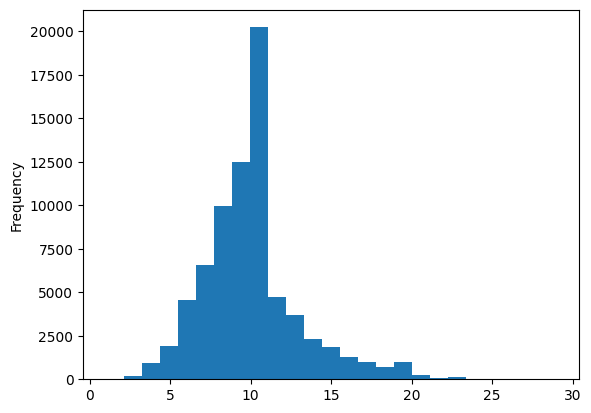

In [ ]:
train_df['Age'].plot.hist(bins=25)

In [ ]:
train_df.head()

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74051 entries, 0 to 74050
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              74051 non-null  int64  
 1   Sex             74051 non-null  object 
 2   Length          74051 non-null  float64
 3   Diameter        74051 non-null  float64
 4   Height          74051 non-null  float64
 5   Weight          74051 non-null  float64
 6   Shucked Weight  74051 non-null  float64
 7   Viscera Weight  74051 non-null  float64
 8   Shell Weight    74051 non-null  float64
 9   Age             74051 non-null  int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 5.6+ MB


### 설명 변수: 데이터 분포 확인

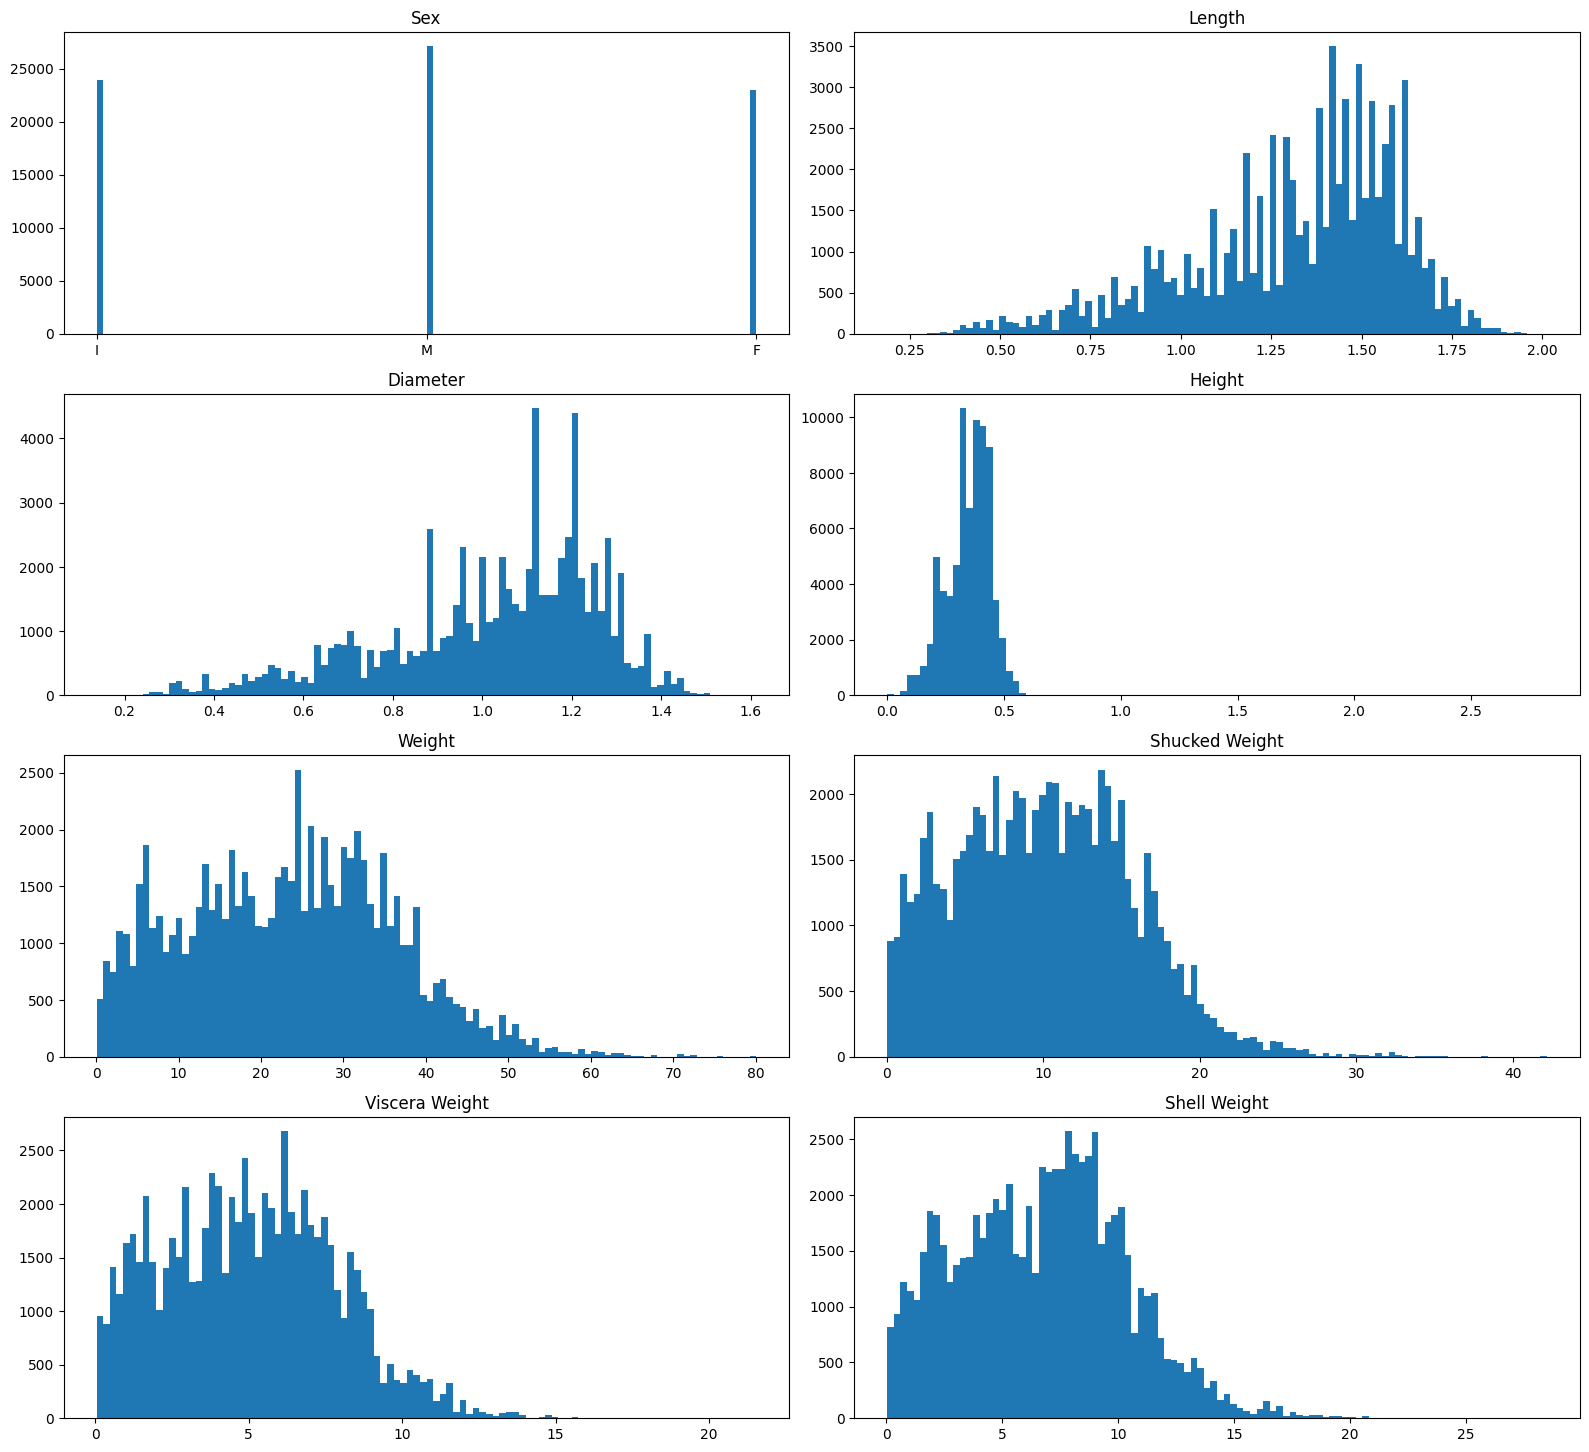

In [ ]:
figure = plt.figure(figsize=(16, 18))
col_arr = train_df.drop(['id', 'Age'], axis=1).columns

count = 0
for i in range(len(col_arr)):
    feat_name = col_arr[i]
    plt.subplot(5, 2, count+1)
    plt.hist(train_df[feat_name], bins=100)
    plt.title(f'{feat_name}')
    count += 1
figure.tight_layout(h_pad=1.0, w_pad=0.8)
plt.show()

([<matplotlib.axis.XTick at 0x7ff7d17e1690>,
 [Text(1, 0, 'Length'), Text(2, 0, 'Diameter'), Text(3, 0, 'Height')])

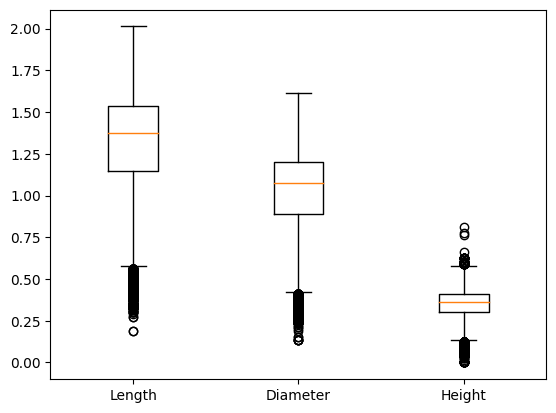

In [ ]:
plt.boxplot(train_df[['Length', 'Diameter', 'Height']])
plt.xticks([1, 2, 3], ['Length', 'Diameter', 'Height'])

([<matplotlib.axis.XTick at 0x7ff7d190b580>,
 [Text(1, 0, 'Weight'),
  Text(2, 0, 'Shucked Weight'),
  Text(3, 0, 'Viscera Weight'),
  Text(4, 0, 'Shell Weight')])

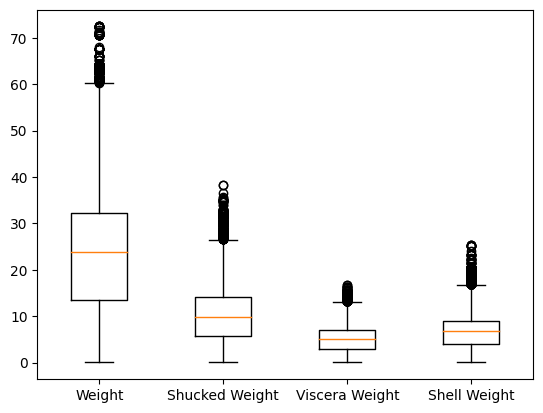

In [ ]:
plt.boxplot(x = train_df[['Weight', 'Shucked Weight', 'Viscera Weight', 'Shell Weight']])
plt.xticks([1, 2, 3, 4], ['Weight', 'Shucked Weight', 'Viscera Weight', 'Shell Weight'])

In [ ]:
train_df['Height'].sort_values(ascending=False).head(50)

56040    0.8125
48826    0.7750
73664    0.7625
31547    0.6625
8001     0.6250
18229    0.6250
47639    0.6250
36366    0.6250
9738     0.6250
10356    0.6250
6096     0.6250
22016    0.6250
55550    0.6250
55990    0.6250
27762    0.6250
55843    0.6250
29268    0.6250
9137     0.6125
43306    0.6000
52834    0.6000
22860    0.6000
65514    0.6000
24572    0.6000
69815    0.6000
44465    0.6000
71746    0.6000
44054    0.6000
60454    0.6000
33824    0.6000
51262    0.6000
27692    0.5875
65276    0.5875
29393    0.5875
27590    0.5875
71695    0.5875
69554    0.5875
25374    0.5875
57533    0.5875
45784    0.5875
50005    0.5875
8346     0.5875
63080    0.5875
72768    0.5875
15630    0.5875
33839    0.5875
48108    0.5875
18493    0.5875
22697    0.5875
66936    0.5875
17087    0.5750
Name: Height, dtype: float64

- 데이터 분포 확인

<Axes: >

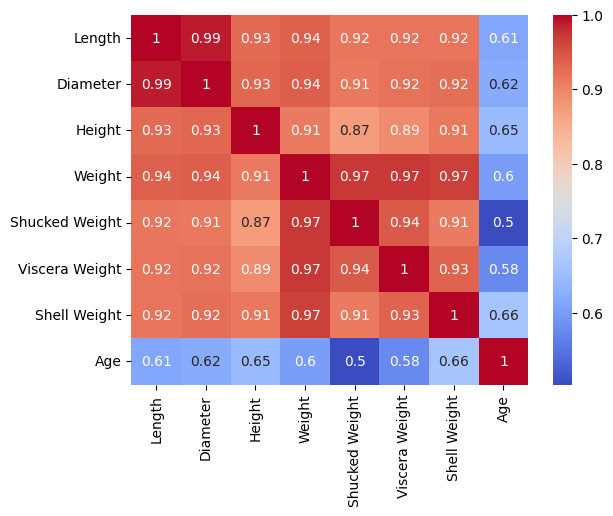

In [ ]:
sns.heatmap(train_df.drop(['id'], axis=1).corr(), annot=True, cmap='coolwarm')

### 이상치 제거

In [ ]:
train_df = train_df.drop(train_df[train_df['Height'] > 1.0].index)
train_df = train_df.drop(train_df[train_df['Weight'] > 75].index)
train_df = train_df.drop(train_df[train_df['Shucked Weight'] > 40].index)
train_df = train_df.drop(train_df[train_df['Viscera Weight'] > 17].index)
train_df = train_df.drop(train_df[train_df['Shell Weight'] > 26].index)

## 테스트 데이터

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49368 entries, 0 to 49367
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              49368 non-null  int64  
 1   Sex             49368 non-null  object 
 2   Length          49368 non-null  float64
 3   Diameter        49368 non-null  float64
 4   Height          49368 non-null  float64
 5   Weight          49368 non-null  float64
 6   Shucked Weight  49368 non-null  float64
 7   Viscera Weight  49368 non-null  float64
 8   Shell Weight    49368 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 3.4+ MB


### 결측치 확인
- 결측치 없음

In [ ]:
test_df.isnull().sum()

id                0
Sex               0
Length            0
Diameter          0
Height            0
Weight            0
Shucked Weight    0
Viscera Weight    0
Shell Weight      0
dtype: int64

# LightGBM을 활용한 모델
- optuna를 활용한 하이퍼파라미터 최적화
- kfold를 활용한 교차검증
- score: 1.38033

## Sex 인코딩
- F = 0
- I = 1
- M = 2

In [ ]:
# 훈련 데이터와 테스트 데이터를 all_df로 결합
all_df = pd.concat([train_df, test_df], ignore_index=True)
all_df.head()

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9.0
1,1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8.0
2,2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9.0
3,3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11.0
4,4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8.0


In [ ]:
all_df = pd.get_dummies(all_df, columns=['Sex'])

In [ ]:
all_df.head()

,id,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,Sex_F,Sex_I,Sex_M
0,0,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9.0,0,1,0
1,1,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8.0,0,1,0
2,2,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9.0,0,0,1
3,3,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11.0,1,0,0
4,4,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8.0,0,1,0


## 훈련 데이터 및 테스트 데이터 분리

In [ ]:
train_df_le = all_df[~all_df['Age'].isnull()]
test_df_le = all_df[all_df['Age'].isnull()]

#train_df_le['Age'] = np.log(train_df_le['Age'])

## 훈련 데이터 제곱근 취하기
- 이거 했더니 2.4 나옴 ;;

In [ ]:
#tmp = train_df_le.drop(['Sex'], axis=1)
#tmp = np.sqrt(tmp)
#tmp['Sex'] = train_df_le['Sex']
#train_df_le = tmp

In [ ]:
#sns.heatmap(data = train_df_le.drop(['id'], axis=1).corr(), cmap='Blues', annot=True)

## 훈련 데이터 및 검증 데이터 분리

In [ ]:
train_X = train_df_le.drop(["Age", "id"], axis = 1)
train_Y = train_df_le["Age"]

## 하이퍼파라미터 최적화 및 모델 학습

In [ ]:
def objective(trial):
    params = {
        # 조정하고자 하는 모델의 하이퍼파라미터 및 탐색 범위 설정
        "objective":"regression",
        "random_seed":1234,
        "learning_rate":0.05,
        "n_extimators":300,
        "num_leaves":trial.suggest_int("num_leaves", 4, 64),
        "max_bin":trial.suggest_int("max_bin", 50, 200),
        "bagging_fraction":trial.suggest_uniform("bagging_fraction", 0.4, 0.9),
        "bagging_freq":trial.suggest_int("bagging_freq", 1, 10),
        "feature_fraction":trial.suggest_uniform("feature_fraction", 0.4, 0.9),
        "min_data_in_leaf":trial.suggest_int("min_data_in_leaf", 2, 16),
        "min_sum_hessian_in_leaf":trial.suggest_int("min_sum_hessian_in_leaf", 1, 10)
    }

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

    model_lgb = lgb.train(params,
                          lgb_train,
                          valid_sets=lgb_eval,
                          num_boost_round=100,
                          early_stopping_rounds=20,
                          verbose_eval=10)

    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    score = np.sqrt(mean_absolute_error(y_valid, y_pred))
    return score
X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_Y, test_size=0.2, random_state=1234)
study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
study.optimize(objective, n_trials=20)
study.best_params

[I 2023-06-06 03:24:01,219] A new study created in memory with name: no-name-5273a9e9-7f72-46c9-b34e-01257fa57d9c


[LightGBM] [Warning] Unknown parameter: n_extimators
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: n_extimators
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.104961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 929
[LightGBM] [Info] Number of data points in the train set: 59225, number of used features: 10
[LightGBM] [Warning] Unknown parameter: n_extimators
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 9.956387
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 6.9851
[20]	valid_0's l2: 5.65474
[30]	valid_0's l2: 4.99802
[40]	valid_0's l2: 4.72563
[50]	valid_0's l2: 4.58121
[60]	valid_0's l2: 4.50155
[70]	valid_0's l2: 4.45907
[80]	valid_0's l2: 4.43102
[90]	valid_0's l2: 4.41219


[I 2023-06-06 03:24:04,816] Trial 0 finished with value: 1.195147609757179 and parameters: {'num_leaves': 37, 'max_bin': 157, 'bagging_fraction': 0.7013816880358219, 'bagging_freq': 6, 'feature_fraction': 0.6118273996694523, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 5}. Best is trial 0 with value: 1.195147609757179.


[100]	valid_0's l2: 4.40257
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 4.40257
[LightGBM] [Warning] Unknown parameter: n_extimators
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: n_extimators
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1081
[LightGBM] [Info] Number of data points in the train set: 59225, number of used features: 10
[LightGBM] [Warning] Unknown parameter: n_extimators
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 9.956387
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 6.88932
[20]	valid_0's l2: 5.51611
[30]	valid_0's l2: 4.87794
[40]	valid_0's l2: 4.61234
[50]	valid_0's l2: 4.489
[60]	valid_0's l2: 4.4409
[70]	valid_0

[I 2023-06-06 03:24:05,724] Trial 1 finished with value: 1.1925802783240518 and parameters: {'num_leaves': 58, 'max_bin': 195, 'bagging_fraction': 0.5917207594128888, 'bagging_freq': 8, 'feature_fraction': 0.6644474598764523, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 10}. Best is trial 1 with value: 1.1925802783240518.


[100]	valid_0's l2: 4.38087
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 4.38087
[LightGBM] [Warning] Unknown parameter: n_extimators
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: n_extimators
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 435
[LightGBM] [Info] Number of data points in the train set: 59225, number of used features: 10
[LightGBM] [Warning] Unknown parameter: n_extimators
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 9.956387
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 7.28341
[20]	valid_0's l2: 5.99692
[30]	valid_0's l2: 5.37093
[40]	valid_0's l2: 5.03111
[50]	valid_0's l2: 4.84725
[60]	valid_0's l2: 4.73799


[I 2023-06-06 03:24:06,222] Trial 2 finished with value: 1.2075511081074481 and parameters: {'num_leaves': 8, 'max_bin': 63, 'bagging_fraction': 0.4101091987201629, 'bagging_freq': 9, 'feature_fraction': 0.7890783754749253, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 10}. Best is trial 1 with value: 1.1925802783240518.


[70]	valid_0's l2: 4.66867
[80]	valid_0's l2: 4.61748
[90]	valid_0's l2: 4.57728
[100]	valid_0's l2: 4.54955
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 4.54955
[LightGBM] [Warning] Unknown parameter: n_extimators
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: n_extimators
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 737
[LightGBM] [Info] Number of data points in the train set: 59225, number of used features: 10
[LightGBM] [Warning] Unknown parameter: n_extimators
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 9.956387
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 6.88555
[20]	valid_0's l2: 5.52303
[30]	valid_0's l2: 4.89635
[40]	valid

[I 2023-06-06 03:24:07,221] Trial 3 finished with value: 1.1933035316826275 and parameters: {'num_leaves': 52, 'max_bin': 119, 'bagging_fraction': 0.7902645881432278, 'bagging_freq': 2, 'feature_fraction': 0.7199605106637619, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 10}. Best is trial 1 with value: 1.1925802783240518.


[LightGBM] [Warning] Unknown parameter: n_extimators
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: n_extimators
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 707
[LightGBM] [Info] Number of data points in the train set: 59225, number of used features: 10
[LightGBM] [Warning] Unknown parameter: n_extimators
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 9.956387
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 6.99596
[20]	valid_0's l2: 5.67651
[30]	valid_0's l2: 5.01911
[40]	valid_0's l2: 4.73638
[50]	valid_0's l2: 4.59613
[60]	valid_0's l2: 4.52436
[70]	valid_0's l2: 4.48041
[80]	valid_0's l2: 4.44965
[90]	valid_0's l2: 4.43273


[I 2023-06-06 03:24:08,019] Trial 4 finished with value: 1.196387643846003 and parameters: {'num_leaves': 35, 'max_bin': 112, 'bagging_fraction': 0.5322778060523135, 'bagging_freq': 8, 'feature_fraction': 0.6280751661082743, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 1}. Best is trial 1 with value: 1.1925802783240518.


[100]	valid_0's l2: 4.42553
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 4.42553
[LightGBM] [Warning] Unknown parameter: n_extimators
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: n_extimators
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 848
[LightGBM] [Info] Number of data points in the train set: 59225, number of used features: 10
[LightGBM] [Warning] Unknown parameter: n_extimators
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 9.956387
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 6.91707
[20]	valid_0's l2: 5.56111
[30]	valid_0's l2: 4.92246
[40]	valid_0's l2: 4.65451
[50]	valid_0's l2: 4.52483
[60]	valid_0's l2: 4.46413
[70]	valid

[I 2023-06-06 03:24:08,894] Trial 5 finished with value: 1.1931002934281474 and parameters: {'num_leaves': 41, 'max_bin': 142, 'bagging_fraction': 0.7084669984373785, 'bagging_freq': 10, 'feature_fraction': 0.7409101495517417, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 5}. Best is trial 1 with value: 1.1925802783240518.


[LightGBM] [Warning] Unknown parameter: n_extimators
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: n_extimators
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 59225, number of used features: 10
[LightGBM] [Warning] Unknown parameter: n_extimators
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 9.956387
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 7.07919
[20]	valid_0's l2: 5.75829
[30]	valid_0's l2: 5.1111
[40]	valid_0's l2: 4.82922
[50]	valid_0's l2: 4.67671
[60]	valid_0's l2: 4.57872
[70]	valid_0's l2: 4.52327
[80]	valid_0's l2: 4.49398


[I 2023-06-06 03:24:09,788] Trial 6 finished with value: 1.1985769763014051 and parameters: {'num_leaves': 46, 'max_bin': 59, 'bagging_fraction': 0.7333833577228339, 'bagging_freq': 7, 'feature_fraction': 0.5051912805369205, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 4}. Best is trial 1 with value: 1.1925802783240518.


[90]	valid_0's l2: 4.47348
[100]	valid_0's l2: 4.45496
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 4.45496
[LightGBM] [Warning] Unknown parameter: n_extimators
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: n_extimators
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 823
[LightGBM] [Info] Number of data points in the train set: 59225, number of used features: 10
[LightGBM] [Warning] Unknown parameter: n_extimators
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 9.956387
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 7.12297
[20]	valid_0's l2: 5.8071
[30]	valid_0's l2: 5.16591
[40]	valid_0's l2: 4.8764
[50]	valid_0's l2: 4.70768
[60]	valid_0

[I 2023-06-06 03:24:10,556] Trial 7 finished with value: 1.199227015305065 and parameters: {'num_leaves': 26, 'max_bin': 136, 'bagging_fraction': 0.6193007567311601, 'bagging_freq': 10, 'feature_fraction': 0.45102240537401406, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 2}. Best is trial 1 with value: 1.1925802783240518.


[LightGBM] [Warning] Unknown parameter: n_extimators
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: n_extimators
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 583
[LightGBM] [Info] Number of data points in the train set: 59225, number of used features: 10
[LightGBM] [Warning] Unknown parameter: n_extimators
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 9.956387
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 7.07772
[20]	valid_0's l2: 5.74604
[30]	valid_0's l2: 5.10554
[40]	valid_0's l2: 4.82439
[50]	valid_0's l2: 4.66876
[60]	valid_0's l2: 4.56404
[70]	valid_0's l2: 4.51201
[80]	valid_0's l2: 4.48196


[I 2023-06-06 03:24:11,428] Trial 8 finished with value: 1.1977927766396914 and parameters: {'num_leaves': 43, 'max_bin': 88, 'bagging_fraction': 0.6331553864281532, 'bagging_freq': 3, 'feature_fraction': 0.4794847918227599, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 7}. Best is trial 1 with value: 1.1925802783240518.


[90]	valid_0's l2: 4.46204
[100]	valid_0's l2: 4.44102
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 4.44102
[LightGBM] [Warning] Unknown parameter: n_extimators
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: n_extimators
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 531
[LightGBM] [Info] Number of data points in the train set: 59225, number of used features: 10
[LightGBM] [Warning] Unknown parameter: n_extimators
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 9.956387
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 7.39734
[20]	valid_0's l2: 6.02856
[30]	valid_0's l2: 5.4671
[40]	valid_0's l2: 5.20591
[50]	valid_0's l2: 5.00233
[60]	valid_

[I 2023-06-06 03:24:12,061] Trial 9 finished with value: 1.2117385941088805 and parameters: {'num_leaves': 12, 'max_bin': 79, 'bagging_fraction': 0.5843625853304821, 'bagging_freq': 9, 'feature_fraction': 0.44855063789653066, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 1}. Best is trial 1 with value: 1.1925802783240518.


[90]	valid_0's l2: 4.63864
[100]	valid_0's l2: 4.6006
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 4.6006
[LightGBM] [Warning] Unknown parameter: n_extimators
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: n_extimators
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009810 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 742
[LightGBM] [Info] Number of data points in the train set: 59225, number of used features: 10
[LightGBM] [Warning] Unknown parameter: n_extimators
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 9.956387
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 6.81979
[20]	valid_0's l2: 5.41025
[30]	valid_0's l2: 4.82246
[40]	valid_0's l2: 4.58422
[50]	valid_0's l2: 4.47612
[60]	valid_0

[I 2023-06-06 03:24:16,445] Trial 10 finished with value: 1.193404854014493 and parameters: {'num_leaves': 63, 'max_bin': 120, 'bagging_fraction': 0.8883805440951686, 'bagging_freq': 7, 'feature_fraction': 0.7696317896991509, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 3}. Best is trial 1 with value: 1.1925802783240518.


[90]	valid_0's l2: 4.38758
[100]	valid_0's l2: 4.38584
Did not meet early stopping. Best iteration is:
[94]	valid_0's l2: 4.38449
[LightGBM] [Warning] Unknown parameter: n_extimators
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: n_extimators
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 615
[LightGBM] [Info] Number of data points in the train set: 59225, number of used features: 10
[LightGBM] [Warning] Unknown parameter: n_extimators
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 9.956387
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 7.21427
[20]	valid_0's l2: 5.93769
[30]	valid_0's l2: 5.30287
[40]	valid_0's l2: 4.99855
[50]	valid_0's l2: 4.8163
[60]	valid_0

[I 2023-06-06 03:24:17,022] Trial 11 finished with value: 1.2054212347635587 and parameters: {'num_leaves': 11, 'max_bin': 94, 'bagging_fraction': 0.45936385947712205, 'bagging_freq': 4, 'feature_fraction': 0.607131497257335, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 7}. Best is trial 1 with value: 1.1925802783240518.


[80]	valid_0's l2: 4.58239
[90]	valid_0's l2: 4.54332
[100]	valid_0's l2: 4.51781
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 4.51781
[LightGBM] [Warning] Unknown parameter: n_extimators
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: n_extimators
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 594
[LightGBM] [Info] Number of data points in the train set: 59225, number of used features: 10
[LightGBM] [Warning] Unknown parameter: n_extimators
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 9.956387
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 6.93273
[20]	valid_0's l2: 5.56817
[30]	valid_0's l2: 4.93458
[40]	valid_0's l2: 4.66889
[50]	valid

[I 2023-06-06 03:24:17,764] Trial 12 finished with value: 1.1942971077958184 and parameters: {'num_leaves': 38, 'max_bin': 90, 'bagging_fraction': 0.6616240267333499, 'bagging_freq': 1, 'feature_fraction': 0.6879732477780897, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 4}. Best is trial 1 with value: 1.1925802783240518.


[LightGBM] [Warning] Unknown parameter: n_extimators
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: n_extimators
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005964 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 471
[LightGBM] [Info] Number of data points in the train set: 59225, number of used features: 10
[LightGBM] [Warning] Unknown parameter: n_extimators
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 9.956387
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 7.07785
[20]	valid_0's l2: 5.74651
[30]	valid_0's l2: 5.10107
[40]	valid_0's l2: 4.81861
[50]	valid_0's l2: 4.66551
[60]	valid_0's l2: 4.5624
[70]	valid_0's l2: 4.50855
[80]	valid_0's l2: 4.48018
[90]	valid_0's l2: 4.46005
[100]	valid_0's l2: 4.44273
Did no

[I 2023-06-06 03:24:18,699] Trial 13 finished with value: 1.1977714396034775 and parameters: {'num_leaves': 44, 'max_bin': 69, 'bagging_fraction': 0.7581636020592828, 'bagging_freq': 3, 'feature_fraction': 0.49159568100355844, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 1}. Best is trial 1 with value: 1.1925802783240518.


[LightGBM] [Warning] Unknown parameter: n_extimators
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: n_extimators
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004929 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 351
[LightGBM] [Info] Number of data points in the train set: 59225, number of used features: 10
[LightGBM] [Warning] Unknown parameter: n_extimators
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 9.956387
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 6.85097
[20]	valid_0's l2: 5.43919
[30]	valid_0's l2: 4.85917
[40]	valid_0's l2: 4.6113
[50]	valid_0's l2: 4.50201
[60]	valid_0's l2: 4.45734
[70]	valid_0's l2: 4.42744
[80]	valid_0's l2: 4.41162
[90]	valid_0's l2: 4.40533
[100]	valid_0's l2: 4.40301
Did no

[I 2023-06-06 03:24:19,700] Trial 14 finished with value: 1.1942740324773322 and parameters: {'num_leaves': 54, 'max_bin': 50, 'bagging_fraction': 0.7389082683981151, 'bagging_freq': 3, 'feature_fraction': 0.7675970110612975, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 3}. Best is trial 1 with value: 1.1925802783240518.


[LightGBM] [Warning] Unknown parameter: n_extimators
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: n_extimators
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 835
[LightGBM] [Info] Number of data points in the train set: 59225, number of used features: 10
[LightGBM] [Warning] Unknown parameter: n_extimators
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 9.956387
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 6.83385
[20]	valid_0's l2: 5.41077
[30]	valid_0's l2: 4.84356
[40]	valid_0's l2: 4.59874
[50]	valid_0's l2: 4.48399
[60]	valid_0's l2: 4.43118
[70]	valid_0's l2: 4.40669


[I 2023-06-06 03:24:20,600] Trial 15 finished with value: 1.193170375739985 and parameters: {'num_leaves': 39, 'max_bin': 139, 'bagging_fraction': 0.6861259528954367, 'bagging_freq': 3, 'feature_fraction': 0.8763745057584925, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 9}. Best is trial 1 with value: 1.1925802783240518.


[80]	valid_0's l2: 4.39305
[90]	valid_0's l2: 4.38418
[100]	valid_0's l2: 4.37832
Did not meet early stopping. Best iteration is:
[99]	valid_0's l2: 4.37782
[LightGBM] [Warning] Unknown parameter: n_extimators
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: n_extimators
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 615
[LightGBM] [Info] Number of data points in the train set: 59225, number of used features: 10
[LightGBM] [Warning] Unknown parameter: n_extimators
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 9.956387
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 6.85722
[20]	valid_0's l2: 5.43832
[30]	valid_0's l2: 4.85033
[40]	valid_0's l2: 4.59972
[50]	valid_

[I 2023-06-06 03:24:21,585] Trial 16 finished with value: 1.1926711650889505 and parameters: {'num_leaves': 46, 'max_bin': 94, 'bagging_fraction': 0.8068989098512387, 'bagging_freq': 4, 'feature_fraction': 0.8405515985555808, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 9}. Best is trial 1 with value: 1.1925802783240518.


[90]	valid_0's l2: 4.38004
[100]	valid_0's l2: 4.3784
Did not meet early stopping. Best iteration is:
[99]	valid_0's l2: 4.37796
[LightGBM] [Warning] Unknown parameter: n_extimators
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: n_extimators
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005005 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 937
[LightGBM] [Info] Number of data points in the train set: 59225, number of used features: 10
[LightGBM] [Warning] Unknown parameter: n_extimators
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 9.956387
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 6.91057
[20]	valid_0's l2: 5.54297
[30]	valid_0's l2: 4.90807
[40]	valid_0's l2: 4.64625
[50]	valid_0's l2: 4.51463
[60]	valid_0

[I 2023-06-06 03:24:22,486] Trial 17 finished with value: 1.192996165903969 and parameters: {'num_leaves': 46, 'max_bin': 159, 'bagging_fraction': 0.6506621909633512, 'bagging_freq': 10, 'feature_fraction': 0.7219950996148188, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 7}. Best is trial 1 with value: 1.1925802783240518.


[100]	valid_0's l2: 4.38574
Did not meet early stopping. Best iteration is:
[99]	valid_0's l2: 4.38521
[LightGBM] [Warning] Unknown parameter: n_extimators
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: n_extimators
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004706 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 621
[LightGBM] [Info] Number of data points in the train set: 59225, number of used features: 10
[LightGBM] [Warning] Unknown parameter: n_extimators
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 9.956387
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 7.48363
[20]	valid_0's l2: 6.27185
[30]	valid_0's l2: 5.68462
[40]	valid_0's l2: 5.37818
[50]	valid_0's l2: 5.16727
[60]	valid_0's l2: 5.02941
[70]	valid_

[I 2023-06-06 03:24:22,977] Trial 18 finished with value: 1.2239321002774972 and parameters: {'num_leaves': 5, 'max_bin': 95, 'bagging_fraction': 0.7300867687463426, 'bagging_freq': 3, 'feature_fraction': 0.7090077144994208, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 2}. Best is trial 1 with value: 1.1925802783240518.


[80]	valid_0's l2: 4.86249
[90]	valid_0's l2: 4.79715
[100]	valid_0's l2: 4.74955
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 4.74955
[LightGBM] [Warning] Unknown parameter: n_extimators
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: n_extimators
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 823
[LightGBM] [Info] Number of data points in the train set: 59225, number of used features: 10
[LightGBM] [Warning] Unknown parameter: n_extimators
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 9.956387
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 7.0042
[20]	valid_0's l2: 5.66559
[30]	valid_0's l2: 5.0171
[40]	valid_0's l2: 4.73736
[50]	valid_0

[I 2023-06-06 03:24:23,739] Trial 19 finished with value: 1.1956215405936739 and parameters: {'num_leaves': 22, 'max_bin': 136, 'bagging_fraction': 0.6954363806240866, 'bagging_freq': 6, 'feature_fraction': 0.7266004099285668, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 5}. Best is trial 1 with value: 1.1925802783240518.


[80]	valid_0's l2: 4.4404
[90]	valid_0's l2: 4.42138
[100]	valid_0's l2: 4.40946
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 4.40946


{'num_leaves': 58,
 'max_bin': 195,
 'bagging_fraction': 0.5917207594128888,
 'bagging_freq': 8,
 'feature_fraction': 0.6644474598764523,
 'min_data_in_leaf': 10,
 'min_sum_hessian_in_leaf': 10}

In [ ]:
"""
lgbm_params = {'learning_rate':0.05,
               'num_iterations':1000,
               'num_leaves': 60,
               'max_bin': 157,
               'bagging_fraction': 0.8994235032839333,
               'bagging_freq': 2,
               'feature_fraction': 0.8340630286841071,
               'min_data_in_leaf': 4,
               'min_sum_hessian_in_leaf': 7
               }
               """
lgbm_params = {'learning_rate':0.05,
               'num_iterations':1000,
               'num_leaves': 58,
               'max_bin': 195,
               'bagging_fraction': 0.5917207594128888,
               'bagging_freq': 8,
               'feature_fraction': 0.6644474598764523,
               'min_data_in_leaf': 10,
               'min_sum_hessian_in_leaf': 10
               }

In [ ]:
kfolds = 5
kf = KFold(n_splits=kfolds)

models = []
maes = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb.train)

    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          valid_sets=lgb_eval,
                          early_stopping_rounds=20,
                          verbose_eval=10)

    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_mae = np.sqrt(mean_absolute_error(y_valid, y_pred))
    print(tmp_mae)

    models.append(model_lgb)
    maes.append(tmp_mae)
    oof[val_index] = y_pred

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1083
[LightGBM] [Info] Number of data points in the train set: 59225, number of used features: 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 9.968409
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 6.55144
[20]	valid_0's l2: 5.13248
[30]	valid_0's l2: 4.56018
[40]	valid_0's l2: 4.33339
[50]	valid_0's l2: 4.23666
[60]	valid_0's l2: 4.18697
[70]	valid_0's l2: 4.15734
[80]	valid_0's l2: 4.14862
[90]	valid_0's l2: 4.14582
[100]	valid_0's l2: 4.14033
[110]	valid_0's l2: 4.13998
[120]	valid_0's l2: 4.14039
Early stopping, best iteration is:
[107]	valid_0's l2: 4.13852
1.1788504497630188
[LightGBM] [Warning] Foun

## 실제값과 예측값 비교
- 실제값을 못따라가고 가운데 머물고 있네?
- 어떻게 이걸 처리 한담...

In [ ]:
actual_pred_df = pd.DataFrame({"actual" : train_Y, "pred" : oof})

<Axes: >

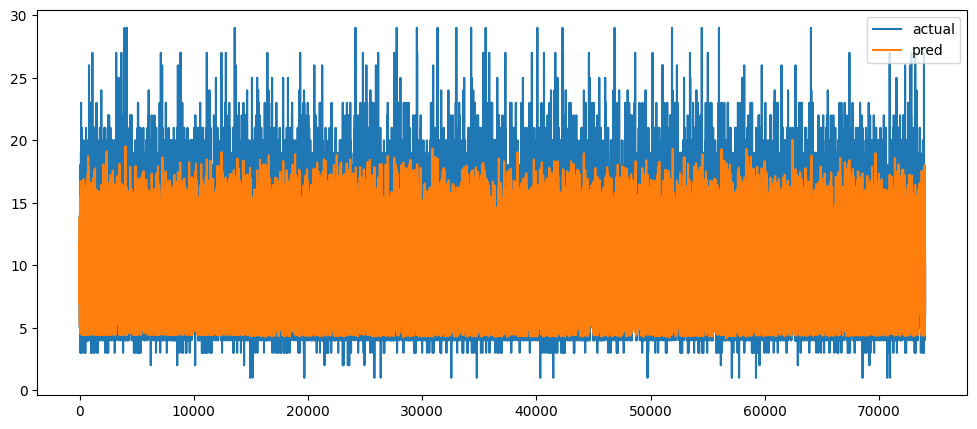

In [ ]:
actual_pred_df.plot(figsize=(12, 5))

<Axes: >

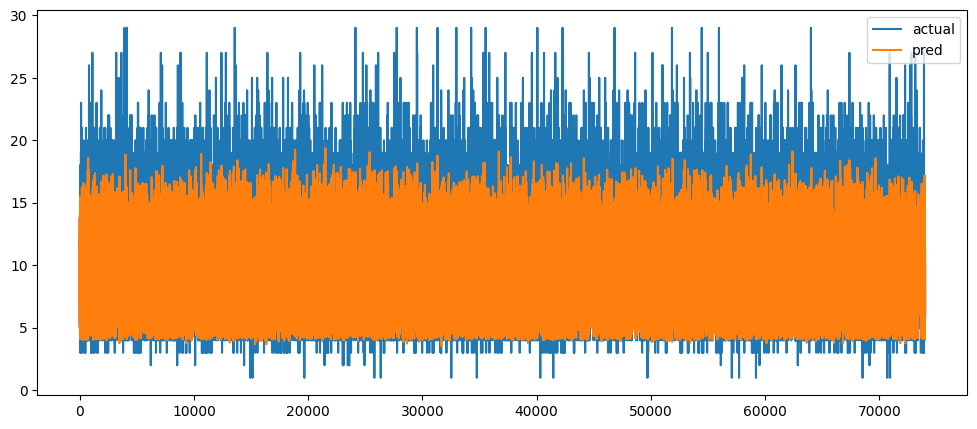

In [ ]:
actual_pred_df.plot(figsize=(12, 5))

## 테스트 데이터 예측 및 제출
- Score: 1.40559 -> 1.38033
- 반올림해서 정수로 바꾸니까 점수 더 올라감

In [ ]:
test_X = test_df_le.drop(['id', 'Age'], axis=1)
preds = []
for model in models:
    pred = model.predict(test_X)
    preds.append(pred)

In [ ]:
preds_array = np.array(preds)
preds_mean = np.mean(preds_array, axis=0)
#preds_mean = np.exp(preds_mean)

In [ ]:
submission['Age'] = np.around(preds_mean).astype('int64')

In [ ]:
submission.to_csv('./drive/MyDrive/crab_age_submit09.csv', index=False)